<a href="https://colab.research.google.com/github/sahug/ds-wandb/blob/main/WANDB%20-%20Session%201%20-%20%20Integrate%20Weights%20%26%20Biases%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WANDB - Session 1 -  Integrate Weights & Biases with PyTorch**

Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.

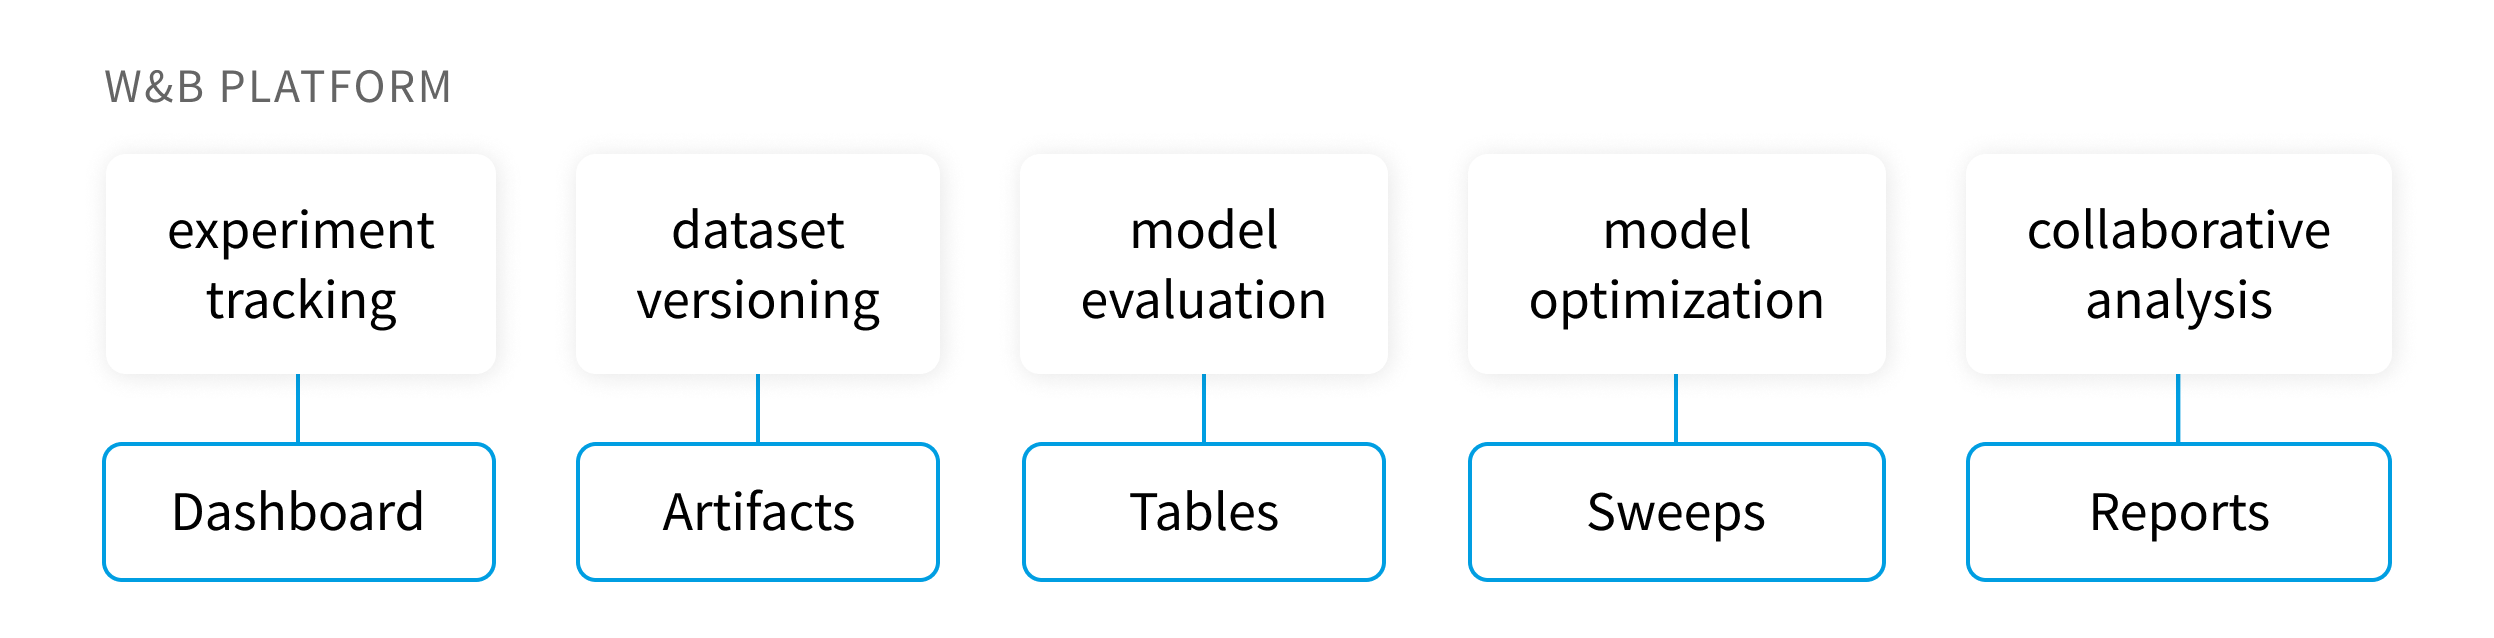

**Install, Import and Log In**

In [ ]:
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transformers
from tqdm.notebook import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Step 1: Install WandB**

In [ ]:
%%capture
!pip install wandb --upgrade

**Step 2: Import W&B and Login**

In order to log data to our web services you'll need to log in.

If its the first time using W&B you'll need to sign up for a free account.

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Define Experiment and Pipeline**

**Step 3: Track Metadata and Hyperparameters with** `wandb.init`

Programmatically, the first thing we do is define our experiment: what are the hyperparameters? what metadata is associated with this run?

It's a pretty common workflow to store this information in a config dictionary (or similar object) and then access it as needed.

For this example, we're only letting a few hyperparameters vary and hand-coding the rest. But any part of your model can be part of the config!

We also include some metadata: we're using the MNIST dataset and a convolutional architecture. If we later work with, say, fully-connected architectures on CIFAR in the same project, this will help us separate our runs.

In [ ]:
config = dict(
    epochs = 5,
    classes = 10,
    kernels = [16, 32],
    batch_size = 128,
    learning_rate = 0.005,
    dataset = "MNIST",
    architecture = "CNN"
)

Now, let's define the overall pipeline, which is pretty typical for model-training:

1. We first `make` a model, plus associated data and optimizer, then
2. We `train` the model accordingly and finally
3. `Test` it to see how training went.

We'll implement these functions below.

In [ ]:
def model_pipeline(hyperparameters):
  
  #Tell W&B to get started
  with wandb.init(project="pytorch-demo", config=hyperparameters):

    #Access all HPs through wandb.config(), so logging matches execution
    config = wandb.config

    #Make the model, data and optimization problem
    model, train_loader, test_loader, criterion, optimizer = make(config)
    print(model)

    #Train model
    train(model, train_loader, criterion, optimizer, config)

    #Test performance
    test(model, test_loader)

    return model


The only difference here from a standard pipeline is that it all occurs inside the context of `wandb.init`. Calling this function sets up a line of communication between your code and our servers.

Passing the `config` dictionary to `wandb.init` immediately logs all that information to us, so you'll always know what hyperparameter values you set your experiment to use.

To ensure the values you chose and logged are always the ones that get used in your model, we recommend using the wandb.config copy of your object. Check the definition of `make` below to see some examples.

**Side Note**: We take care to run our code in separate processes, so that any issues on our end (e.g. a giant sea monster attacks our data centers) don't crash your code. Once the issue is resolved (e.g. the Kraken returns to the deep) you can log the data with `wandb sync`.

In [17]:
def make(config):
  
  #Make the data
  train, test = get_data(train=True), get_data(train=False)
  train_loader = make_loader(train, batch_size=config.batch_size)
  test_loader = make_loader(test, batch_size=config.batch_size)

  #Make the model
  model = ConvNet(config.kernels, config.classes).to(device)

  #Make the loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

  return model, train_loader, test_loader, criterion, optimizer

**Define the Data Loading and Model**

Now, we need to specify how the data is loaded and what the model looks like.

This part is very important, but it's no different from what it would be without `wandb`, so we won't dwell on it.

In [15]:
def get_data(slice=5, train=True):
  full_dataset = torchvision.datasets.MNIST(root=".", train=train, transform=torchvision.transforms.ToTensor(), download=True)

  #Slice data. Equiv to slicing with[::slice]
  sub_dataset = torch.utils.data.Subset(full_dataset, indices=range(0, len(full_dataset), slice))

  return sub_dataset

In [8]:
def make_loader(dataset, batch_size):
  loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
  return loader

Defining the model is normally the fun part!

But nothing changes with `wandb`, so we're gonna stick with a standard `ConvNet` architecture.

Don't be afraid to mess around with this and try some experiments -- all your results will be logged on `wandb.ai`!

In [19]:
#Conventional and Convolutionla NN

class ConvNet(nn.Module):

  def __init__(self, kernels, classes=10):
    super(ConvNet, self).__init__()

    self.layer1=nn.Sequential(
        nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2=nn.Sequential(
        nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc=nn.Linear(7*7*kernels[-1], classes)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

**Define Training Logic**

Moving on in our `model_pipeline`, it's time to specify how we train.

Two wandb functions come into play here: `watch` and `log`.

**Step 3. Track gradients with `wandb.watch` and everything else with `wandb.log`**

`wandb.watch` will log the gradients and the parameters of your model, every `log_freq` steps of training.

All you need to do is call it before you start training.

The rest of the training code remains the same: we iterate over epochs and batches, running forward and backward passes and applying our `optimizer`.

In [10]:
def train(model, loader, criterion, optimizer, config):
  
  #Tell wandb to watch what the model gets up to: gradients, weights and more!
  wandb.watch(model, criterion, log="all", log_freq=10)

  #Run training and track with wandb
  total_batches = len(loader) * config.epochs
  example_ct = 0
  batch_ct = 0

  for epoch in tqdm(range(config.epochs)):
    for _, (images, labels) in enumerate(loader):
      loss = train_batch(images, labels, model, optimizer, criterion)
      example_ct += len(images)
      batch_ct += 1

      #Report metrics every 25th batch
      if((batch_ct + 1) % 25) == 0:
        train_log(loss, example_ct, epoch)

In [11]:
def train_batch(images, labels, model, optimizer, criterion):
  images, labels = images.to(device), labels.to(device)

  #Forward pass
  outputs = model(images)
  loss = criterion(outputs, labels)

  #Backward pass
  optimizer.zero_grad()
  loss.backward()

  #Step with optimizer
  optimizer.step()

  return loss

The only difference is in the logging code: where previously you might have reported metrics by printing to the terminal, now you pass the same information to `wandb.log`.

`wandb.log` expects a dictionary with strings as keys. These strings identify the objects being logged, which make up the values. You can also optionally log which `step` of training you're on.

**Side Note:** I like to use the number of examples the model has seen, since this makes for easier comparison across batch sizes, but you can use raw steps or batch count. For longer training runs, it can also make sense to log by `epoch`.

In [21]:
def train_log(loss, example_ct, epoch):
  loss = float(loss)

  #Log to wandb
  wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
  print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

**Define Testing Logic**

Once the model is done training, we want to test it: run it against some fresh data from production, perhaps, or apply it to some hand-curated "hard examples".

**Step 4: Call wandb.save (Optional)**

This is also a great time to save the model's architecture and final parameters to disk. For maximum compatibility, we'll export our model in the `Open Neural Network eXchange (ONNX)` format.

Passing that filename to wandb.save ensures that the model parameters are saved to W&B's servers: no more losing track of which `.h5` or `.pb` corresponds to which training runs!

For more advanced wandb features for storing, versioning, and distributing models, check out our Artifacts tools.

In [23]:
def test(model, test_loader):
  model.eval()

  #Run the model on some test example
  with torch.no_grad():
    correct, total = 0,0
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the {total} " + f"test images: {100 * correct / total}%")

    wandb.log({"text_accuracy" : correct/total})
  
  #Save the model in the exchangable ONNX format
  torch.onnx.export(model, images, "model.onnx")
  wandb.save("model.onnx")

**Run training and watch your metrics live on wandb.ai!**

Now that we've defined the whole pipeline and slipped in
those few lines of W&B code,
we're ready to run our fully-tracked experiment.

We'll report a few links to you:
our documentation,
the Project page, which organizes all the runs in a project, and
the Run page, where this run's results will be stored.

Navigate to the Run page and check out these tabs:

1. **Charts**, where the model gradients, parameter values, and loss are logged throughout training
2. **System**, which contains a variety of system metrics, including Disk I/O utilization, CPU and GPU metrics (watch that temperature soar 🔥), and more
3. **Logs**, which has a copy of anything pushed to standard out during training
4. **Files**, where, once training is complete, you can click on the `model.onnx` to view our network with the [Netron model viewer](https://github.com/lutzroeder/netron).

Once the run in finished
(i.e. the `with wandb.init` block is exited),
we'll also print a summary of the results in the cell output.

In [24]:
#Build, train and analyze the model with the pipeline
model = model_pipeline(config)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03072 examples: 0.572
Loss after 06272 examples: 0.207
Loss after 09472 examples: 0.168
Loss after 12640 examples: 0.208
Loss after 15840 examples: 0.076
Loss after 19040 examples: 0.101
Loss after 22240 examples: 0.047
Loss after 25408 examples: 0.115
Loss after 28608 examples: 0.069
Loss after 31808 examples: 0.097
Loss after 35008 examples: 0.028
Loss after 38176 examples: 0.038
Loss after 41376 examples: 0.057
Loss after 44576 examples: 0.015
Loss after 47776 examples: 0.058
Loss after 50944 examples: 0.024
Loss after 54144 examples: 0.049
Loss after 57344 examples: 0.063
Accuracy of the model on the 1951 test images: 0.0%



epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
loss,█▃▃▃▂▂▁▂▂▂▁▁▂▁▂▁▁▂
text_accuracy,▁
epoch,4
loss,0.06348
text_accuracy,0.0


Now we can go to the link for Synced stoic-cloud-6 and look at all the metrices collected in the WANDB website.